<a href="https://colab.research.google.com/github/SauravMaheshkar/medical/blob/main/fMRI/CLIPvoxel_to_CLIPimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes CLIP-voxels (brain voxels that have already been mapped to CLIP space via contrastive learning) and then uses a diffusion model to better align these CLIP-voxels to CLIP-image space (i.e., this is how DallE-2 uses a diffusion prior to go from CLIP-text space to CLIP-image space, as the spaces are still disjointed after contrastive learning).

# Import packages & functions

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import math
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import pandas as pd
from collections import OrderedDict

from utils import * 
from models import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

seed_everything(seed=0)

/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda


In [2]:
# setup multi-gpu Data Distributed Processing (ddp) if available
# if not using ddp, using_ddp should be False and local_rank=0
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import ddp_config
using_ddp, local_rank = ddp_config.ddp_test()
if device=='cuda':
    torch.cuda.set_device(local_rank)

NOT using distributed parallel processing!


In [3]:
# if full_training is True, use large batches and the entire training dataset 
full_training = True
print('full_training:',full_training)

full_training: True


## Which pretrained model are you using for voxel alignment to embedding space? 

In [4]:
img_augmentation = True # do image augmentation?
soft_clip = True # use loss_nce + loss_soft? (seems to improve fwd/bwd retrieval)
clamp_embs = False # clamp embeddings to (-1.5, 1.5)
norm_embs = False # L2 norm embeddings after clamping
temperature = None # temperature for InfoNCE and softclip

model_name = f'clip_image_vitL_aug{img_augmentation}_soft{soft_clip}_clamp{clamp_embs}_norm{norm_embs}_temp{temperature}' # CLIP ViT-L/14 image embeddings
# model_name = 'clip_text_vitL' # CLIP ViT-L/14 text embeddings
# model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

print(f"Using model: {model_name}")
print(f"Image augmentation: {img_augmentation}")

Using model: clip_image_vitL_augTrue_softTrue_clampFalse_normFalse_tempNone
Image augmentation: True


In [5]:
if "resnet" in model_name: 
    clip_extractor = Clipper("RN50", clamp_embs=clamp_embs, norm_embs=norm_embs)
elif "vitL" in model_name: 
    clip_extractor = Clipper("ViT-L/14", clamp_embs=clamp_embs, norm_embs=norm_embs)
elif "vitB" in model_name: 
    clip_extractor = Clipper("ViT-B/32", clamp_embs=clamp_embs, norm_embs=norm_embs)

if "text" in model_name:     
    image_var = 'trial' 
else:
    image_var = 'images'
print("image_var =", image_var)

# # load COCO annotations curated in the same way as the mind_reader (Lin Sprague Singh) preprint
# f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
# subj01_order = f['subj01'][:]
# f.close()
# annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
# subj01_annots = annots[subj01_order]

ViT-L/14 cuda
image_var = images


# Prep dataloaders and brain_to_clip model

In [28]:
batch_size = 128
num_devices = torch.cuda.device_count()
num_workers = num_devices
train_dl, val_dl = get_dataloaders(batch_size, image_var, num_workers=num_workers)

batch_size 128
num_devices 1
num_workers 1
global_batch_size 128
num_worker_batches 195
validation: num_worker_batches 4


In [8]:
# from models.py
brain_net = BrainNetwork(768) 
if using_ddp:
    brain_net0 = brain_net.to(local_rank)
    brain_net = DDP(brain_net0, device_ids=[local_rank])
else:
    brain_net = brain_net.to(device)

# Train Diffusion Prior

This will map the CLIP-voxel embeddings to the CLIP-image embeddings space. Right now they are disjointed embedding spaces despite being aligned to maximize same-pair cosine similarity.

In [9]:
# Loading checkpoint  
# ckpt_path = f'checkpoints/{model_name}_subj01_epoch19.pth'
# ckpt_path = f'checkpoints/clip_image_vitL_augTrue_softTrue_clampFalse_normFalse_subj01_epoch19.pth'\
## nothing but the state_dict in this one
ckpt_path = f'/home/jimgoo/data/neuro/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best.pth'
print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)    
if 'model_state_dict' in checkpoint:
    brain_net.load_state_dict(checkpoint['model_state_dict'])
else:
    brain_net.load_state_dict(checkpoint)
brain_net.eval()
brain_net.requires_grad_(False);

ckpt_path /home/jimgoo/data/neuro/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best.pth


In [10]:
from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior

prior_network = DiffusionPriorNetwork(
    dim = 768,
    depth = 6,
    dim_head = 64,
    heads = 8
).to(device)

diffusion_prior = DiffusionPrior(
    net = prior_network,
    #clip = clip_model,
    image_embed_dim = 768,
    condition_on_text_encodings = False,
    timesteps = 100,
    cond_drop_prob = 0.2
).to(device)

In [11]:
count_params(prior_network)

param counts:
53,302,544 total
53,302,528 trainable


In [12]:
count_params(diffusion_prior)

param counts:
53,302,544 total
53,302,528 trainable


In [13]:
# prior_network

In [14]:
#diffusion_prior

In [15]:
epoch = 0
num_epochs = 60
lr = 3e-4
losses = []
val_losses = []
optimizer = torch.optim.AdamW(diffusion_prior.parameters(), lr=lr)

# resume from checkpoint:
# prior_checkpoint = torch.load(f'{ckpt_path[:-12]}_epoch{epoch}_diffusionprior.pth', 
#                               map_location=device)
# epoch = prior_checkpoint['epoch']+1
# diffusion_prior.load_state_dict(prior_checkpoint['model_state_dict'])
# losses = prior_checkpoint['train_losses']
# optimizer.load_state_dict(prior_checkpoint['optimizer_state_dict'])
# optimizer.param_groups[0]['lr'] = lr

In [16]:
from IPython.display import clear_output

In [17]:
diff_ckpt_path = ckpt_path.replace('.pth', '|') + f'epoch{epoch:03d}_diffusionprior-jimgoo.pth' 
diff_ckpt_path 

'/home/jimgoo/data/neuro/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best|epoch000_diffusionprior-jimgoo.pth'

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 53/60 [5:59:12<53:44, 460.62s/it, loss=19.1, val_loss=51.6]

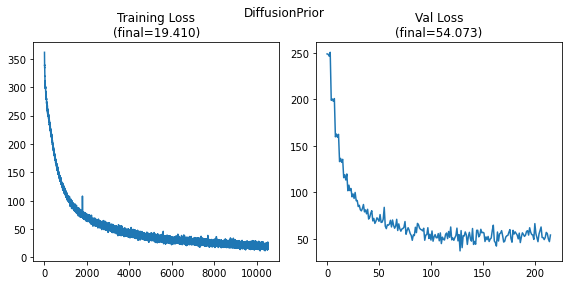

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 54/60 [6:01:51<40:12, 402.06s/it, loss=19.1, val_loss=51.6]


KeyboardInterrupt: 

In [20]:
# feed text and images into diffusion prior network
progress_bar = tqdm(range(epoch,num_epochs),ncols=250)
for epoch in progress_bar:
    diffusion_prior.train()
    for train_i, (voxel, image) in enumerate(train_dl):
        optimizer.zero_grad()
        image = image.to(device)

        clip_embed = brain_net(voxel.to(device).float())
        #clip_embed = nn.functional.normalize(clip_embed,dim=-1)

        # clip_embed = clip_extractor.embed_curated_annotations(subj01_annots[voxel])

        image_clip = clip_extractor.embed_image(image).float()

        loss = diffusion_prior(text_embed=clip_embed, image_embed=image_clip)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    diffusion_prior.eval()
    for val_i, (val_voxel, val_image) in enumerate(val_dl):
        with torch.no_grad(): 
            val_image = val_image.to(device)

            clip_embed = brain_net(val_voxel.to(device).float())
            #clip_embed = nn.functional.normalize(clip_embed,dim=-1)

            # clip_embed = clip_extractor.embed_curated_annotations(subj01_annots[voxel])

            image_clip = clip_extractor.embed_image(val_image).float()

            val_loss = diffusion_prior(text_embed=clip_embed, image_embed=image_clip)

            val_losses.append(val_loss.item())
    
    clear_output(wait=True)
    
    # Save model checkpoint every 5 epochs if full_training==True
    if (epoch+1)%5==0 and full_training:
        diff_ckpt_path = ckpt_path.replace('.pth', '|') + f'epoch{epoch:03d}_diffusionprior-jimgoo.pth'
        
        print(f'saving {diff_ckpt_path}')
        if (using_ddp==False) or (using_ddp==True and local_rank==0):
            state_dict = brain_net.state_dict()
            if using_ddp: # if using DDP, convert DDP state_dict to non-DDP before saving
                for key in list(state_dict.keys()):
                    if 'module.' in key:
                        state_dict[key.replace('module.', '')] = state_dict[key]
                        del state_dict[key]   
            torch.save({
                'epoch': epoch,
                'model_state_dict': diffusion_prior.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': losses,
                'val_losses': val_losses,
                }, diff_ckpt_path)
        if using_ddp:
            dist.barrier() # this tells the other gpus wait for the first gpu to finish saving the model
    
    logs = OrderedDict(
        loss=np.mean(losses[-(train_i+1):]),
        val_loss=np.mean(val_losses[-(val_i+1):]),
    )
    progress_bar.set_postfix(**logs)
    
    plot_prior(losses, val_losses)

In [2]:
# plot_prior(losses, val_losses)

In [21]:
diff_ckpt_path

'/home/jimgoo/data/neuro/clip_image_vitL_2stage_mixco_lotemp_125ep_subj01_best|epoch049_diffusionprior-jimgoo.pth'

In [22]:
#ls checkpoints/*diffusionprior*

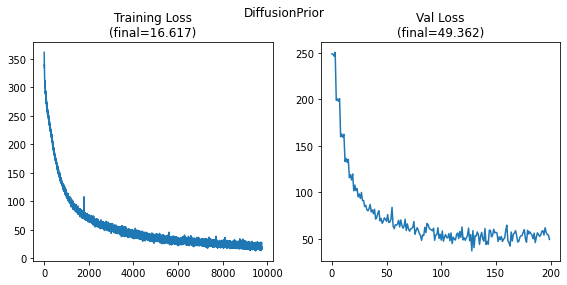

In [23]:
plot_prior_ckpt(diff_ckpt_path)

In [24]:
#plot_prior_ckpt('checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch24_diffusionprior.pth')

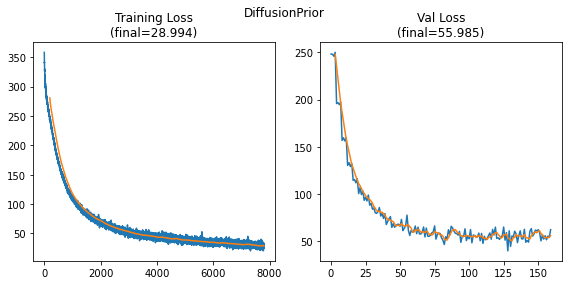

In [101]:
# around 39 epochs is best
plot_prior_ckpt('checkpoints/clip_image_vitL_augTrue_softTrue_subj01_epoch19|epoch39_diffusionprior-jimgoo.pth')

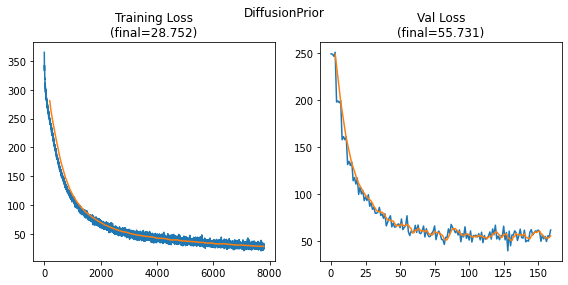

In [102]:
plot_prior_ckpt('checkpoints/clip_image_vitL_augTrue_softTrue_clampFalse_normFalse_subj01_epoch19|epoch039_diffusionprior-jimgoo.pth')

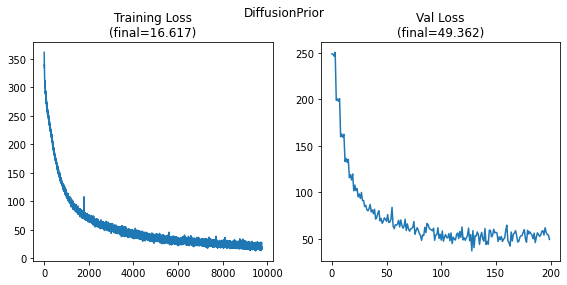

In [26]:
# load pretrained checkpoint
# prior_ckpt_path = f'{ckpt_path[:-12]}_epoch24_diffusionprior.pth'
#prior_ckpt_path = 'checkpoints/clip_image_vitL_augTrue_softTrue_clampFalse_normFalse_subj01_epoch19|epoch039_diffusionprior-jimgoo.pth'
prior_ckpt_path = diff_ckpt_path

prior_checkpoint = torch.load(prior_ckpt_path, map_location=device)
losses = prior_checkpoint['train_losses']
val_losses = prior_checkpoint['val_losses']
diffusion_prior.load_state_dict(prior_checkpoint['model_state_dict'])
diffusion_prior=diffusion_prior.to(device)

diffusion_prior.eval()
diffusion_prior.requires_grad_(False)
prior_network.eval()
prior_network.requires_grad_(False)
brain_net.eval()
brain_net.requires_grad_(False)

plot_prior(losses, val_losses)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd2024c5360>
Traceback (most recent call last):
  File "/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


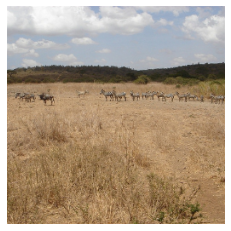

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.39it/s]


Cosine sim for CLIP-voxel x CLIP-image tensor([0.0931], device='cuda:0')
Cosine sim for CLIP-voxel-aligned x CLIP-image tensor([0.7525], device='cuda:0')


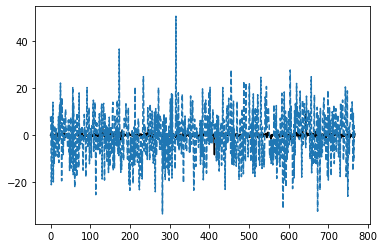

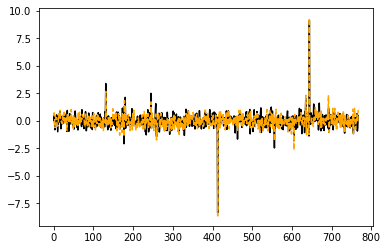

In [29]:
for i, (voxel, image) in enumerate(val_dl):
    image_test = image.to(device)
    clip_embed = brain_net(voxel.to(device).float())
    break

for idx in [22]:
    plt.imshow(torch_to_Image(image_test[idx]))
    plt.axis('off')
    plt.show()

    image_clip = clip_extractor.embed_image(image_test[idx][None])
    orig_vox_clip = clip_embed[idx][None]

    with torch.no_grad():
        align_vox_clip = diffusion_prior.p_sample_loop(clip_embed[idx][None].shape, 
                                                       text_cond = dict(text_embed = clip_embed[idx][None].long()), 
                                                       cond_scale = 1., timesteps = 100)
    
    print("Cosine sim for CLIP-voxel x CLIP-image", nn.functional.cosine_similarity(orig_vox_clip.float(),image_clip,dim=1))
    print("Cosine sim for CLIP-voxel-aligned x CLIP-image",nn.functional.cosine_similarity(align_vox_clip.float(),image_clip,dim=1))

    plt.plot(image_clip.detach().cpu().numpy().flatten(),c='k')
    plt.plot(orig_vox_clip.detach().cpu().numpy().flatten(),ls='--')
    plt.show()

    plt.plot(image_clip.detach().cpu().numpy().flatten(),c='k')
    plt.plot(align_vox_clip.detach().cpu().numpy().flatten(),c='orange',ls='--')
    plt.show()

# Test out feeding these aligned CLIP-voxel embeddings through Stable Diffusion (Image Variation) model

In [30]:
from diffusers import StableDiffusionImageVariationPipeline
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel
from transformers import CLIPVisionModelWithProjection, CLIPFeatureExtractor

cache_dir = '/scratch/gpfs/ps6938/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(cache_dir): # download from huggingface if not already downloaded / cached
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained(
        "lambdalabs/sd-image-variations-diffusers", revision="v2.0").to(device)
    cache_dir = "lambdalabs/sd-image-variations-diffusers"
    
unet = UNet2DConditionModel.from_pretrained(cache_dir,subfolder="unet").to(device)
vae = AutoencoderKL.from_pretrained(cache_dir,subfolder="vae").to(device)
noise_scheduler = PNDMScheduler.from_pretrained(cache_dir, subfolder="scheduler")

unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae.eval() # dont want to train model
vae.requires_grad_(False) # dont need to calculate gradients

def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    return image[0]

print("loaded pre-trained SD model!")

Fetching 11 files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 562.36it/s]


loaded pre-trained SD model!


In [3]:
# sample_images(
#     clip_extractor, brain_net, unet, vae, noise_scheduler, diffusion_prior,
#     voxel, image_test,
#     num_inference_steps=20, clip_guidance_scale=3, vox_guidance_scale=3, num_per_sample=4
# )

emb min/max -7.31640625 7.984375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 52.38it/s]


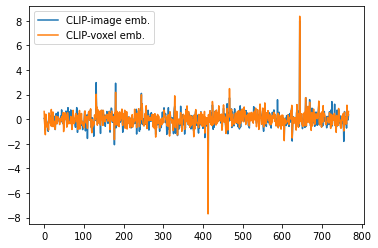

Cosine sim: tensor([0.8573], device='cuda:0')


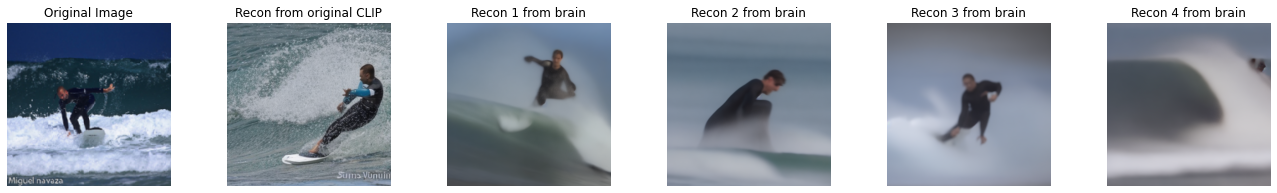

emb min/max -9.421875 10.0234375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.51it/s]


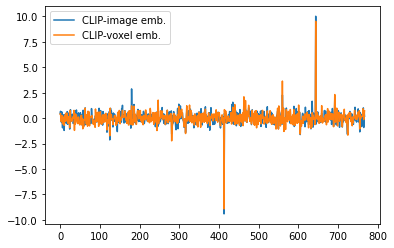

Cosine sim: tensor([0.7785], device='cuda:0')


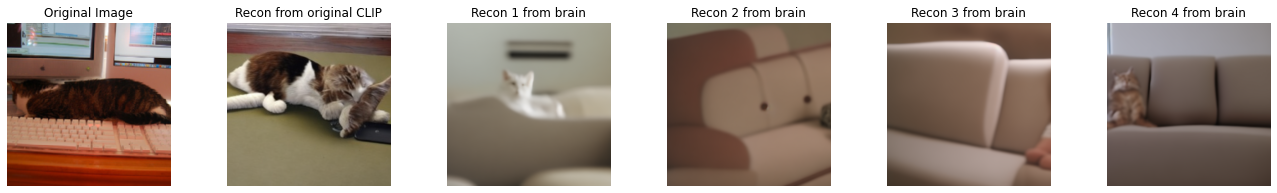

emb min/max -8.6875 9.4375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 50.23it/s]


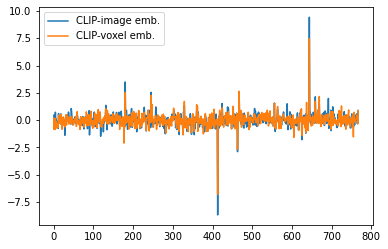

Cosine sim: tensor([0.8293], device='cuda:0')


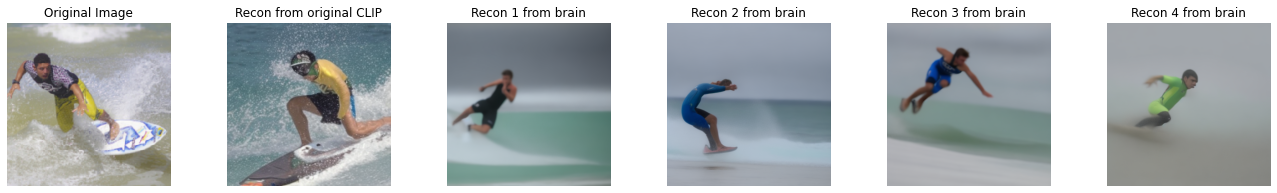

emb min/max -8.359375 8.9921875


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 51.30it/s]


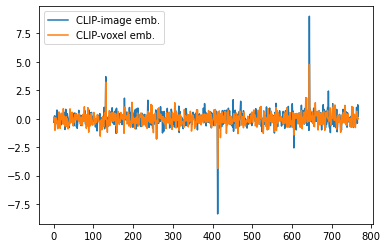

Cosine sim: tensor([0.4936], device='cuda:0')


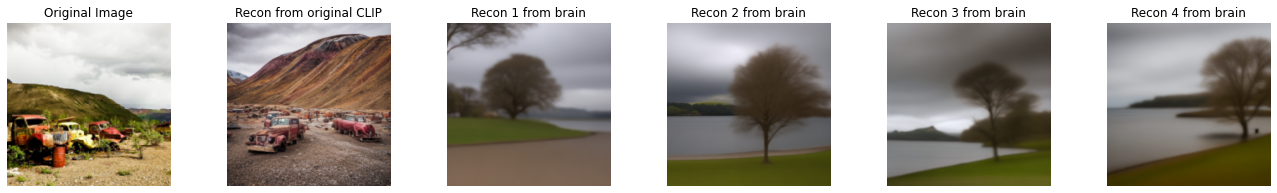

In [117]:
num_inference_steps = 20
clip_guidance_scale = 3 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
vox_guidance_scale = 3
num_per_sample = 4

for idx in range(4):
    image = clip_extractor.resize_image(image_test[[idx]])
    
    # Original clip embedding:
    clip_emb = clip_extractor.embed_image(image)
    print("emb min/max", clip_emb.min().item(), clip_emb.max().item())
    
    clip_emb = torch.cat([torch.zeros_like(clip_emb), clip_emb]).unsqueeze(1).to(device).float()
    clip_latents = torch.randn([1, 4, 64, 64], device=device)

    # Encode voxels to CLIP space
    image_embeddings = brain_net(voxel[[idx]].to(device).float())
    # image_embeddings = nn.functional.normalize(image_embeddings,dim=-1) 
    # image_embeddings *= clip_emb[1].norm()/image_embeddings.norm() # note: this is cheating to equate norm scaling
    image_embeddings = diffusion_prior.p_sample_loop(image_embeddings.shape, 
                                           text_cond = dict(text_embed = image_embeddings), 
                                           cond_scale = 1., timesteps = num_inference_steps)
    plt.plot(clip_emb[1].detach().cpu().numpy().flatten(),label='CLIP-image emb.')
    plt.plot(image_embeddings.detach().cpu().numpy().flatten(),label='CLIP-voxel emb.')
    plt.legend()
    plt.show()
    print("Cosine sim:", nn.functional.cosine_similarity(image_embeddings,clip_emb[1],dim=1))
    
    # duplicate the embedding to serve classifier free guidance
    image_embeddings = image_embeddings.repeat(num_per_sample, 1)
    image_embeddings = torch.cat([torch.zeros_like(image_embeddings), image_embeddings]).unsqueeze(1).to(device)

    # Prepare timesteps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = noise_scheduler.timesteps
    latents = torch.randn([num_per_sample, 4, 64, 64], device=device)
    
    # Denoising loop (original clip)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([clip_latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=clip_emb).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + clip_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        clip_latents = noise_scheduler.step(noise_pred, t, clip_latents).prev_sample
        decoded_clip_image = decode_latents(clip_latents)
    
    # Denoising loop (brain recon)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + vox_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
    fig, ax = plt.subplots(1, 2+num_per_sample, figsize=(23,3))
    ax[0].set_title(f"Original Image")
    ax[0].imshow(torch_to_Image(image))
    ax[1].set_title(f"Recon from original CLIP")
    ax[1].imshow(torch_to_Image(decoded_clip_image))
    for i in range(2,2+num_per_sample):
        recon = decode_latents(latents[i-2].unsqueeze(0))
        ax[i].set_title(f"Recon {i-1} from brain")
        ax[i].imshow(torch_to_Image(recon))
    for i in range(2+num_per_sample):
        ax[i].axis('off')
    plt.show()          

emb min/max -7.31640625 7.984375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.53it/s]


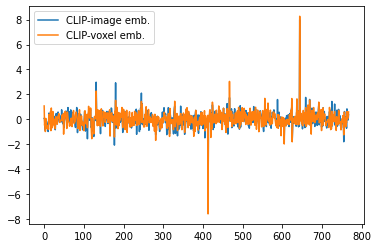

Cosine sim: tensor([0.8132], device='cuda:0')


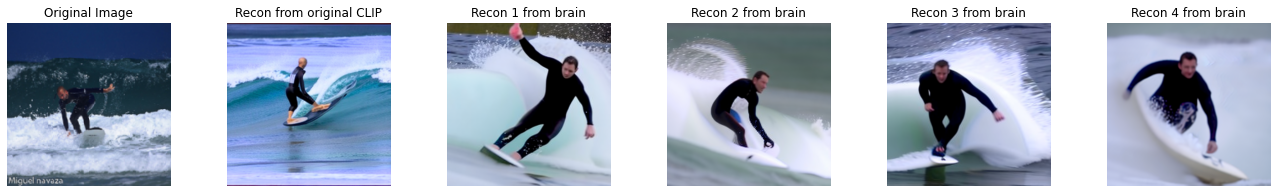

emb min/max -9.421875 10.0234375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 54.70it/s]


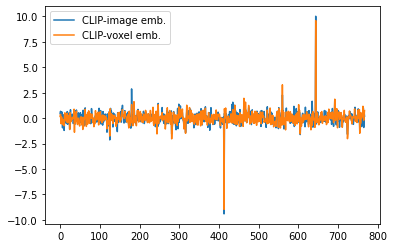

Cosine sim: tensor([0.7885], device='cuda:0')


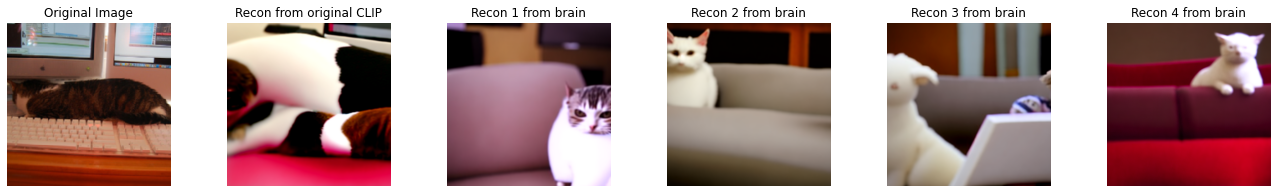

emb min/max -8.6875 9.4375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.01it/s]


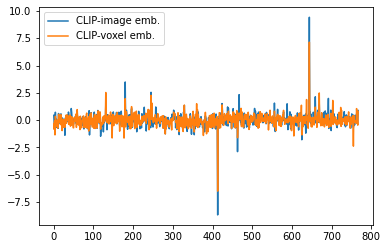

Cosine sim: tensor([0.7855], device='cuda:0')


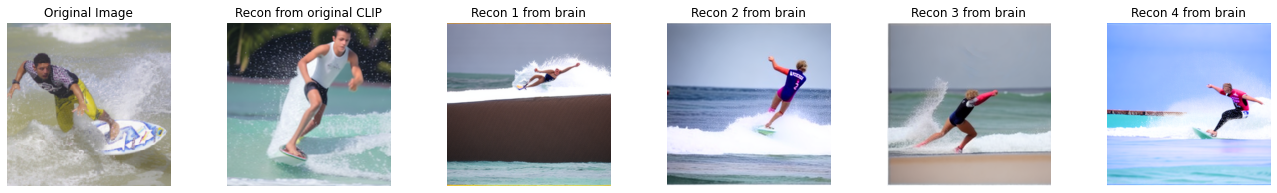

emb min/max -8.359375 8.9921875


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.18it/s]


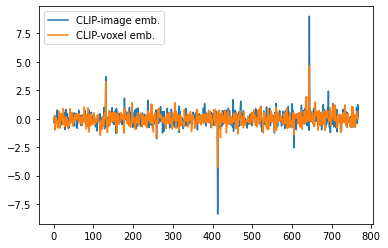

Cosine sim: tensor([0.4847], device='cuda:0')


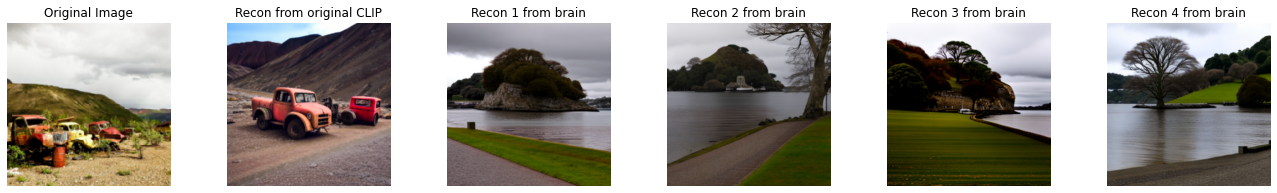

In [119]:
# num_inference_steps = 20
# clip_guidance_scale = 3 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
# vox_guidance_scale = 3
# num_per_sample = 4

num_inference_steps = 50
clip_guidance_scale = 7.5 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
vox_guidance_scale = 7.5
num_per_sample = 4

for idx in range(4):
    image = clip_extractor.resize_image(image_test[[idx]])
    
    # Original clip embedding:
    clip_emb = clip_extractor.embed_image(image)
    print("emb min/max", clip_emb.min().item(), clip_emb.max().item())
    
    clip_emb = torch.cat([torch.zeros_like(clip_emb), clip_emb]).unsqueeze(1).to(device).float()
    clip_latents = torch.randn([1, 4, 64, 64], device=device)

    # Encode voxels to CLIP space
    image_embeddings = brain_net(voxel[[idx]].to(device).float())
    # image_embeddings = nn.functional.normalize(image_embeddings,dim=-1) 
    # image_embeddings *= clip_emb[1].norm()/image_embeddings.norm() # note: this is cheating to equate norm scaling
    image_embeddings = diffusion_prior.p_sample_loop(image_embeddings.shape, 
                                           text_cond = dict(text_embed = image_embeddings), 
                                           cond_scale = 1., timesteps = num_inference_steps)
    plt.plot(clip_emb[1].detach().cpu().numpy().flatten(),label='CLIP-image emb.')
    plt.plot(image_embeddings.detach().cpu().numpy().flatten(),label='CLIP-voxel emb.')
    plt.legend()
    plt.show()
    print("Cosine sim:", nn.functional.cosine_similarity(image_embeddings,clip_emb[1],dim=1))
    
    # duplicate the embedding to serve classifier free guidance
    image_embeddings = image_embeddings.repeat(num_per_sample, 1)
    image_embeddings = torch.cat([torch.zeros_like(image_embeddings), image_embeddings]).unsqueeze(1).to(device)

    # Prepare timesteps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = noise_scheduler.timesteps
    latents = torch.randn([num_per_sample, 4, 64, 64], device=device)
    
    # Denoising loop (original clip)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([clip_latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=clip_emb).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + clip_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        clip_latents = noise_scheduler.step(noise_pred, t, clip_latents).prev_sample
        decoded_clip_image = decode_latents(clip_latents)
    
    # Denoising loop (brain recon)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + vox_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
    fig, ax = plt.subplots(1, 2+num_per_sample, figsize=(23,3))
    ax[0].set_title(f"Original Image")
    ax[0].imshow(torch_to_Image(image))
    ax[1].set_title(f"Recon from original CLIP")
    ax[1].imshow(torch_to_Image(decoded_clip_image))
    for i in range(2,2+num_per_sample):
        recon = decode_latents(latents[i-2].unsqueeze(0))
        ax[i].set_title(f"Recon {i-1} from brain")
        ax[i].imshow(torch_to_Image(recon))
    for i in range(2+num_per_sample):
        ax[i].axis('off')
    plt.show()          

In [122]:
for idx in range(10):
    image = clip_extractor.resize_image(image_test[[idx]])
    
    # Original clip embedding:
    clip_emb = clip_extractor.embed_image(image)
    print(f"emb min/max/norm: {clip_emb.min().item():.3f}, {clip_emb.max().item():.3f}, {clip_emb.norm().item():.3f}")

emb min/max/norm: -7.316, 7.984, 18.312
emb min/max/norm: -9.422, 10.023, 20.016
emb min/max/norm: -8.688, 9.438, 19.406
emb min/max/norm: -8.359, 8.992, 19.062
emb min/max/norm: -8.750, 9.430, 19.469
emb min/max/norm: -8.781, 9.398, 19.234
emb min/max/norm: -8.445, 9.070, 18.766
emb min/max/norm: -9.539, 10.164, 20.188
emb min/max/norm: -6.996, 7.570, 18.234
emb min/max/norm: -7.586, 8.203, 18.031


emb min/max -8.75 9.4296875


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.60it/s]


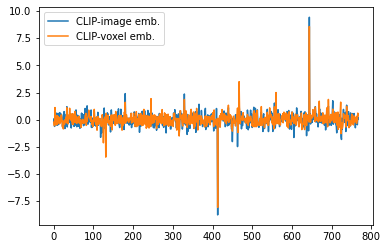

Cosine sim: tensor([0.7010], device='cuda:0')


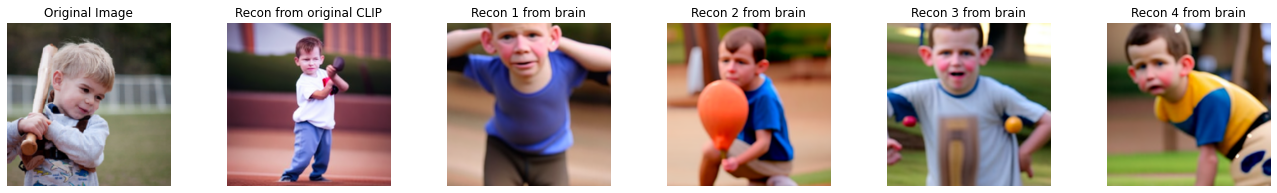

emb min/max -8.78125 9.3984375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.61it/s]


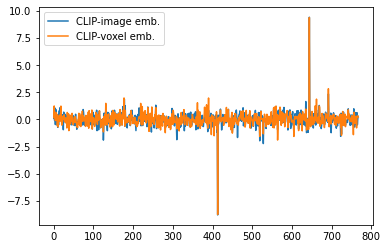

Cosine sim: tensor([0.7853], device='cuda:0')


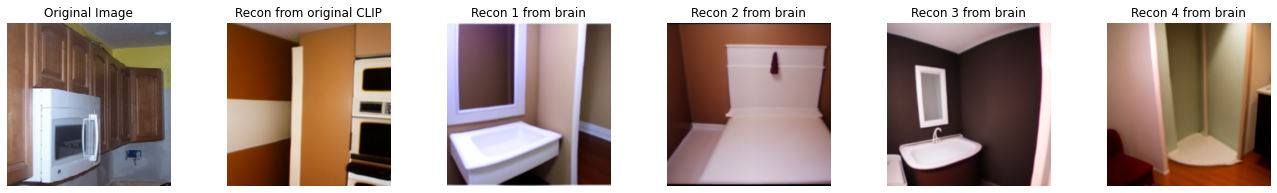

emb min/max -8.4453125 9.0703125


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.08it/s]


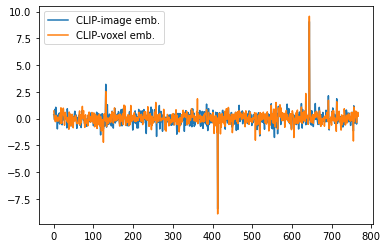

Cosine sim: tensor([0.6993], device='cuda:0')


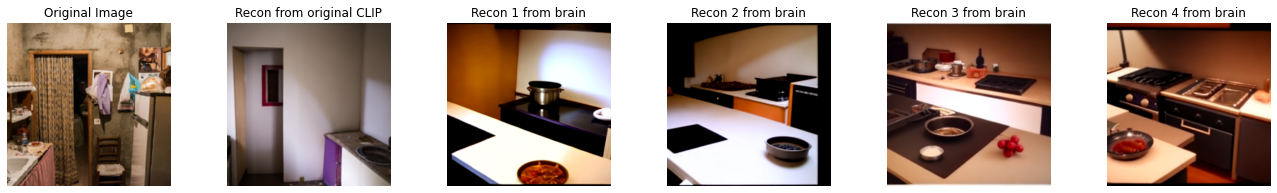

emb min/max -9.5390625 10.1640625


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 53.28it/s]


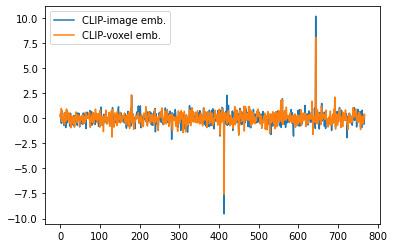

Cosine sim: tensor([0.6552], device='cuda:0')


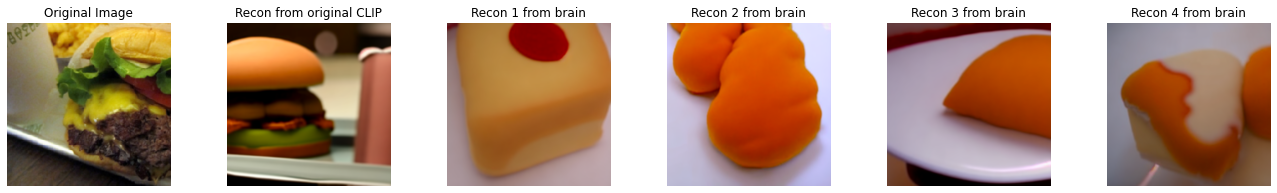

emb min/max -6.99609375 7.5703125


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 55.77it/s]


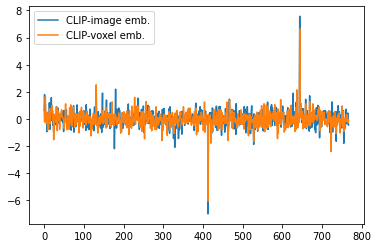

Cosine sim: tensor([0.5210], device='cuda:0')


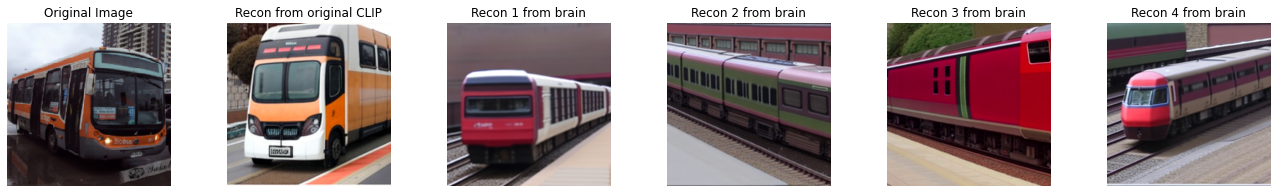

In [123]:
# num_inference_steps = 20
# clip_guidance_scale = 3 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
# vox_guidance_scale = 3
# num_per_sample = 4

num_inference_steps = 50
clip_guidance_scale = 7.5 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
vox_guidance_scale = 7.5
num_per_sample = 4

for idx in range(4, 9):
    image = clip_extractor.resize_image(image_test[[idx]])
    
    # Original clip embedding:
    clip_emb = clip_extractor.embed_image(image)
    print("emb min/max", clip_emb.min().item(), clip_emb.max().item())
    
    clip_emb = torch.cat([torch.zeros_like(clip_emb), clip_emb]).unsqueeze(1).to(device).float()
    clip_latents = torch.randn([1, 4, 64, 64], device=device)

    # Encode voxels to CLIP space
    image_embeddings = brain_net(voxel[[idx]].to(device).float())
    # image_embeddings = nn.functional.normalize(image_embeddings,dim=-1) 
    # image_embeddings *= clip_emb[1].norm()/image_embeddings.norm() # note: this is cheating to equate norm scaling
    image_embeddings = diffusion_prior.p_sample_loop(image_embeddings.shape, 
                                           text_cond = dict(text_embed = image_embeddings), 
                                           cond_scale = 1., timesteps = num_inference_steps)
    plt.plot(clip_emb[1].detach().cpu().numpy().flatten(),label='CLIP-image emb.')
    plt.plot(image_embeddings.detach().cpu().numpy().flatten(),label='CLIP-voxel emb.')
    plt.legend()
    plt.show()
    print("Cosine sim:", nn.functional.cosine_similarity(image_embeddings,clip_emb[1],dim=1))
    
    # duplicate the embedding to serve classifier free guidance
    image_embeddings = image_embeddings.repeat(num_per_sample, 1)
    image_embeddings = torch.cat([torch.zeros_like(image_embeddings), image_embeddings]).unsqueeze(1).to(device)

    # Prepare timesteps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = noise_scheduler.timesteps
    latents = torch.randn([num_per_sample, 4, 64, 64], device=device)
    
    # Denoising loop (original clip)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([clip_latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=clip_emb).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + clip_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        clip_latents = noise_scheduler.step(noise_pred, t, clip_latents).prev_sample
        decoded_clip_image = decode_latents(clip_latents)
    
    # Denoising loop (brain recon)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + vox_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
    fig, ax = plt.subplots(1, 2+num_per_sample, figsize=(23,3))
    ax[0].set_title(f"Original Image")
    ax[0].imshow(torch_to_Image(image))
    ax[1].set_title(f"Recon from original CLIP")
    ax[1].imshow(torch_to_Image(decoded_clip_image))
    for i in range(2,2+num_per_sample):
        recon = decode_latents(latents[i-2].unsqueeze(0))
        ax[i].set_title(f"Recon {i-1} from brain")
        ax[i].imshow(torch_to_Image(recon))
    for i in range(2+num_per_sample):
        ax[i].axis('off')
    plt.show()          

In [31]:
seed_everything(42)

emb min/max -7.31640625 7.984375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 35.47it/s]


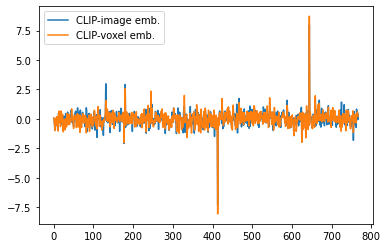

Cosine sim: tensor([0.7961], device='cuda:0')


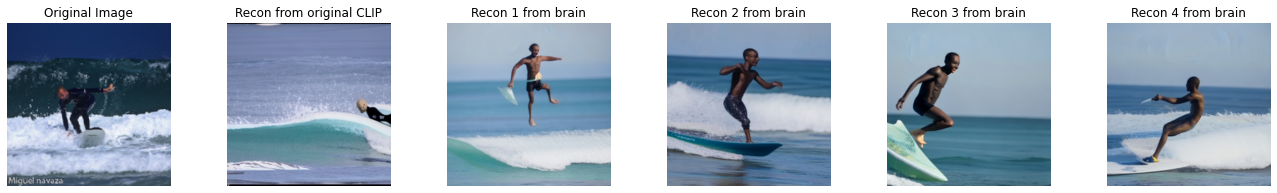

emb min/max -9.421875 10.0234375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 37.20it/s]


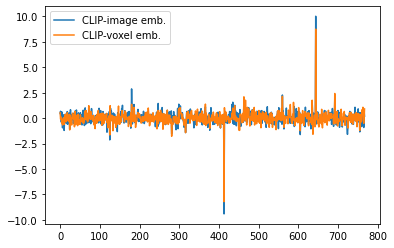

Cosine sim: tensor([0.7098], device='cuda:0')


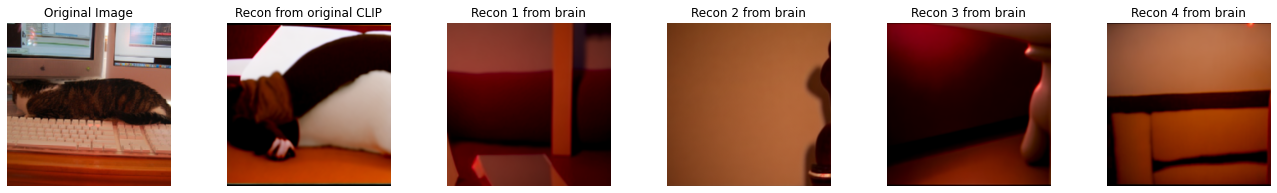

emb min/max -8.6875 9.4375


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 50.41it/s]


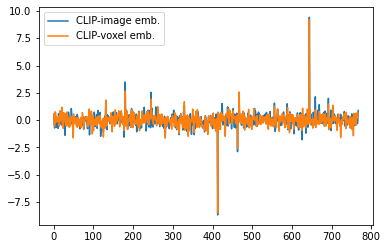

Cosine sim: tensor([0.7137], device='cuda:0')


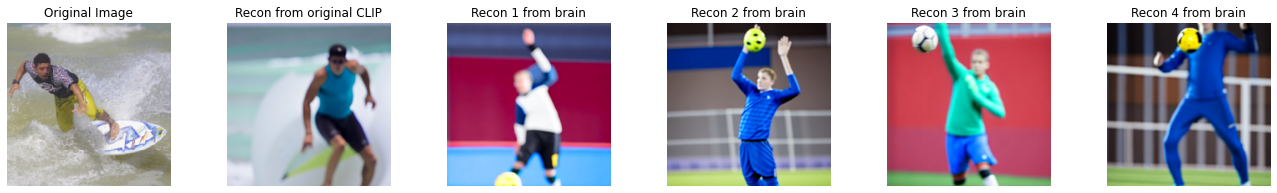

emb min/max -8.359375 8.9921875


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 50.68it/s]


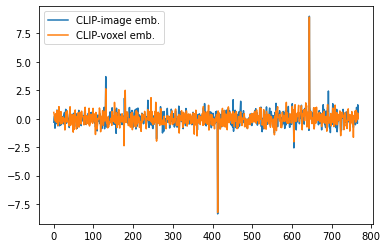

Cosine sim: tensor([0.7206], device='cuda:0')


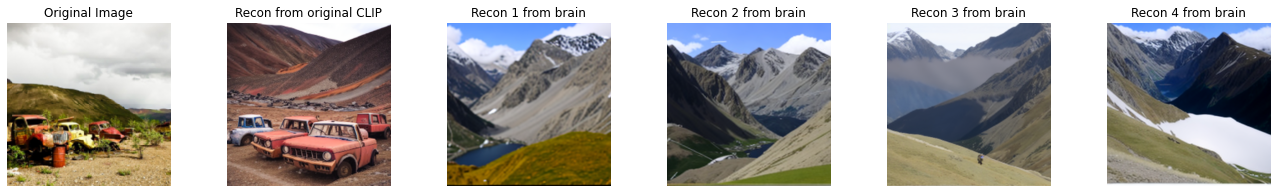

In [32]:
# num_inference_steps = 20
# clip_guidance_scale = 3 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
# vox_guidance_scale = 3
# num_per_sample = 4

num_inference_steps = 50
clip_guidance_scale = 7.5 # guidance scale used in example: https://huggingface.co/lambdalabs/sd-image-variations-diffusers
vox_guidance_scale = 7.5
num_per_sample = 4

for idx in range(4):
    image = clip_extractor.resize_image(image_test[[idx]])
    
    # Original clip embedding:
    clip_emb = clip_extractor.embed_image(image)
    print("emb min/max", clip_emb.min().item(), clip_emb.max().item())
    
    clip_emb = torch.cat([torch.zeros_like(clip_emb), clip_emb]).unsqueeze(1).to(device).float()
    clip_latents = torch.randn([1, 4, 64, 64], device=device)

    # Encode voxels to CLIP space
    image_embeddings = brain_net(voxel[[idx]].to(device).float())
    # image_embeddings = nn.functional.normalize(image_embeddings,dim=-1) 
    # image_embeddings *= clip_emb[1].norm()/image_embeddings.norm() # note: this is cheating to equate norm scaling
    image_embeddings = diffusion_prior.p_sample_loop(image_embeddings.shape, 
                                           text_cond = dict(text_embed = image_embeddings), 
                                           cond_scale = 1., timesteps = num_inference_steps)
    plt.plot(clip_emb[1].detach().cpu().numpy().flatten(),label='CLIP-image emb.')
    plt.plot(image_embeddings.detach().cpu().numpy().flatten(),label='CLIP-voxel emb.')
    plt.legend()
    plt.show()
    print("Cosine sim:", nn.functional.cosine_similarity(image_embeddings,clip_emb[1],dim=1))
    
    # duplicate the embedding to serve classifier free guidance
    image_embeddings = image_embeddings.repeat(num_per_sample, 1)
    image_embeddings = torch.cat([torch.zeros_like(image_embeddings), image_embeddings]).unsqueeze(1).to(device)

    # Prepare timesteps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = noise_scheduler.timesteps
    latents = torch.randn([num_per_sample, 4, 64, 64], device=device)
    
    # Denoising loop (original clip)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([clip_latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=clip_emb).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + clip_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        clip_latents = noise_scheduler.step(noise_pred, t, clip_latents).prev_sample
        decoded_clip_image = decode_latents(clip_latents)
    
    # Denoising loop (brain recon)
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + vox_guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
    fig, ax = plt.subplots(1, 2+num_per_sample, figsize=(23,3))
    ax[0].set_title(f"Original Image")
    ax[0].imshow(torch_to_Image(image))
    ax[1].set_title(f"Recon from original CLIP")
    ax[1].imshow(torch_to_Image(decoded_clip_image))
    for i in range(2,2+num_per_sample):
        recon = decode_latents(latents[i-2].unsqueeze(0))
        ax[i].set_title(f"Recon {i-1} from brain")
        ax[i].imshow(torch_to_Image(recon))
    for i in range(2+num_per_sample):
        ax[i].axis('off')
    plt.show()          